# 1. Imports 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# constants
#path = 'C:/Users/monte/Documents/Memoria/src'
path = 'C:/Users/asus/Documents/2023_2/Memoria/src'

# Ostar
O_df = pd.read_csv(path+'/Data/o_spectral_lines.csv')
# Bstar
B_df = pd.read_csv(path+'/Data/b_spectral_lines.csv')
# Observed spectra
Obs_df = pd.read_csv(path+'/Data/observed_spectral_lines.csv')

# 2. Model Definition

In [2]:
valMAE = {}
obsMAE = {}

In [3]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers 

#input_shape = (4, 10, 128) = (batch_size, steps, vectorLength) = (batchsize, rotaciones, frecuencias)

#normalize = layers.Normalization()

# This layer will shift and scale inputs into a distribution centered around 0 with standard deviation 1.
# It accomplishes this by precomputing the mean and variance of the data and calling (input - mean) / sqrt(var) at runtime

#input_shape = (x_train.shape[1],1)

def generate_model(): 
  return tf.keras.Sequential([
  keras.Input(shape=(701,1)),
  #normalize,
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.MaxPooling1D(pool_size=3, padding='same'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.MaxPooling1D(pool_size=2, padding='same'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.MaxPooling1D(pool_size=2, padding='same'),
  layers.GlobalAveragePooling1D(),
  
  layers.Dense(128, activation='relu'),
  layers.Dense(3, activation='linear')
])

# 2. X: None, Y: MinMax  

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

target = ['temperature','g','v']


X = B_df.drop(target,axis = 1)
Y = B_df[target]

X_obs = Obs_df.drop(target,axis=1)
Y_obs = Obs_df[target]

y_scaler = MinMaxScaler()

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42)
x_obs = X_obs

#x_train = np.random.normal(loc=0, scale=0.01, size=x_train.shape) + x_train

y_scaler = y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)
y_obs = y_scaler.transform(Y_obs)


Text(0, 0.5, 'Intensidad')

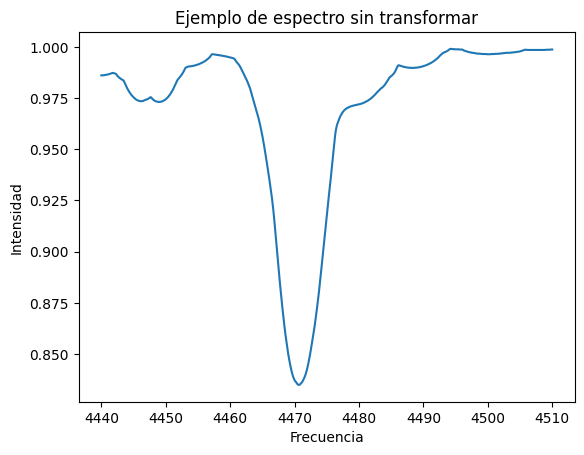

In [5]:
plt.plot(x_train.columns.map(float),x_train.iloc[0])
plt.title('Ejemplo de espectro sin transformar')
plt.xlabel('Frecuencia')
plt.ylabel('Intensidad')

In [6]:
#https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
from keras.optimizers import Adam
from sklearn.model_selection import KFold, StratifiedKFold

kf = KFold(n_splits = 5)

TESTING_LOSS = []
TESTING_MAE = []
VALIDAITON_LOSS = []
VALIDATION_MAE = []
fold_var = 1

for train_index, val_index in kf.split(x_train,y_train):
	x_training = x_train.iloc[train_index]
	x_validation = x_train.iloc[val_index]
	y_training = y_train[train_index]
	y_validation = y_train[val_index]
	
	# CREATE NEW MODEL
	model = generate_model()
	# COMPILE NEW MODEL
	model.compile(loss='MSE',
		      optimizer=Adam(),
		      metrics=['MAE'])
	
	# FIT THE MODEL
	history = model.fit(
  	x = x_training,
  	y = y_training,
		epochs=10,
		validation_data=(x_validation,y_validation))
 
	results = model.evaluate(x_val,y_val)
	results = dict(zip(model.metrics_names,results))
	
	VALIDAITON_LOSS.append(results['loss'])
	VALIDATION_MAE.append(results['MAE'])
 
	results = model.evaluate(x_obs,y_obs)
	results = dict(zip(model.metrics_names,results))
	
	TESTING_LOSS.append(results['loss'])
	TESTING_MAE.append(results['MAE'])
	
	tf.keras.backend.clear_session()
	
	fold_var += 1

Epoch 1/10
489/489 [==============================] - 12s 11ms/step - loss: 0.0871 - MAE: 0.2515 - val_loss: 0.0817 - val_MAE: 0.2454
Epoch 2/10
489/489 [==============================] - 4s 8ms/step - loss: 0.0830 - MAE: 0.2470 - val_loss: 0.0818 - val_MAE: 0.2452
Epoch 3/10
489/489 [==============================] - 4s 8ms/step - loss: 0.0823 - MAE: 0.2464 - val_loss: 0.0827 - val_MAE: 0.2459
Epoch 4/10
489/489 [==============================] - 4s 9ms/step - loss: 0.0823 - MAE: 0.2464 - val_loss: 0.0814 - val_MAE: 0.2451
Epoch 5/10
489/489 [==============================] - 4s 9ms/step - loss: 0.0823 - MAE: 0.2463 - val_loss: 0.0814 - val_MAE: 0.2450
Epoch 6/10
489/489 [==============================] - 4s 8ms/step - loss: 0.0822 - MAE: 0.2463 - val_loss: 0.0819 - val_MAE: 0.2454
Epoch 7/10
489/489 [==============================] - 4s 9ms/step - loss: 0.0822 - MAE: 0.2463 - val_loss: 0.0820 - val_MAE: 0.2455
Epoch 8/10
489/489 [==============================] - 4s 9ms/step - loss: 

In [7]:
valMAE['None'] = VALIDATION_MAE
obsMAE['None'] = TESTING_MAE

# 3. X: MinMax, Y: MinMax  

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

target = ['temperature','g','v']


X = B_df.drop(target,axis = 1)
Y = B_df[target]

X_obs = Obs_df.drop(target,axis=1)
Y_obs = Obs_df[target]

y_scaler = MinMaxScaler()
x_scaler = MinMaxScaler()

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42)

#x_train = np.random.normal(loc=0, scale=0.01, size=x_train.shape) + x_train

y_scaler = y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)
y_obs = y_scaler.transform(Y_obs)

x_scaler = x_scaler.fit(x_train)
x_train = x_scaler.transform(x_train)
x_val = x_scaler.transform(x_val)
x_obs = x_scaler.transform(X_obs.to_numpy())


c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'FDP de una columna(frecuencia)')

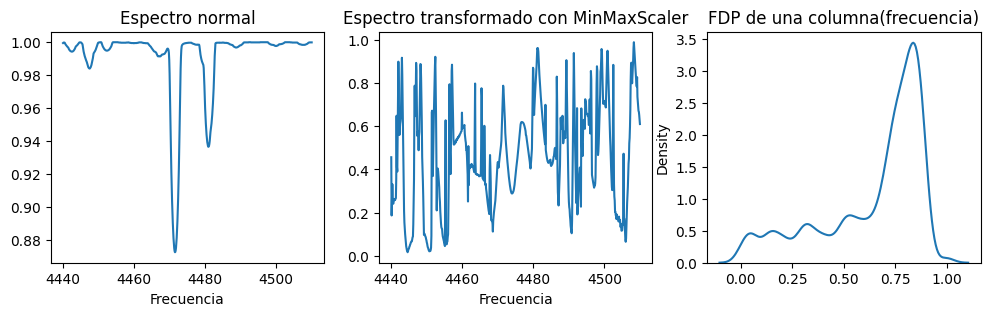

In [9]:
fig, axis = plt.subplots(1, 3, figsize=(12,3))
axis[0].plot(X.columns.map(float),X.iloc[0]); axis[0].set_xlabel('Frecuencia') ; axis[0].set_title('Espectro normal')
axis[1].plot(X.columns.map(float),x_train[0]); axis[1].set_xlabel('Frecuencia') ; axis[1].set_title('Espectro transformado con MinMaxScaler')
sns.kdeplot(x_train[:,0],ax=axis[2]); axis[2].set_title('FDP de una columna(frecuencia)')

In [10]:
#https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
from keras.optimizers import Adam
from sklearn.model_selection import KFold, StratifiedKFold

kf = KFold(n_splits = 5)

TESTING_LOSS = []
TESTING_MAE = []
VALIDAITON_LOSS = []
VALIDATION_MAE = []
fold_var = 1

for train_index, val_index in kf.split(x_train,y_train):
	x_training = x_train[train_index]
	x_validation = x_train[val_index]
	y_training = y_train[train_index]
	y_validation = y_train[val_index]
	
	# CREATE NEW MODEL
	model = generate_model()
	# COMPILE NEW MODEL
	model.compile(loss='MSE',
		      optimizer=Adam(),
		      metrics=['MAE'])
	
	# FIT THE MODEL
	history = model.fit(
  	x = x_training,
  	y = y_training,
		epochs=10,
		validation_data=(x_validation,y_validation))
 
	results = model.evaluate(x_val,y_val)
	results = dict(zip(model.metrics_names,results))
	
	VALIDAITON_LOSS.append(results['loss'])
	VALIDATION_MAE.append(results['MAE'])
 
	results = model.evaluate(x_obs,y_obs)
	results = dict(zip(model.metrics_names,results))
 
	TESTING_LOSS.append(results['loss'])
	TESTING_MAE.append(results['MAE'])
	
	tf.keras.backend.clear_session()
	
	fold_var += 1

Epoch 1/10
489/489 [==============================] - 5s 9ms/step - loss: 0.0545 - MAE: 0.1815 - val_loss: 0.0165 - val_MAE: 0.0946
Epoch 2/10
489/489 [==============================] - 4s 9ms/step - loss: 0.0132 - MAE: 0.0825 - val_loss: 0.0077 - val_MAE: 0.0609
Epoch 3/10
489/489 [==============================] - 4s 9ms/step - loss: 0.0071 - MAE: 0.0588 - val_loss: 0.0048 - val_MAE: 0.0495
Epoch 4/10
489/489 [==============================] - 4s 9ms/step - loss: 0.0049 - MAE: 0.0499 - val_loss: 0.0046 - val_MAE: 0.0536
Epoch 5/10
489/489 [==============================] - 4s 9ms/step - loss: 0.0033 - MAE: 0.0411 - val_loss: 0.0024 - val_MAE: 0.0356
Epoch 6/10
489/489 [==============================] - 4s 9ms/step - loss: 0.0022 - MAE: 0.0343 - val_loss: 0.0014 - val_MAE: 0.0278
Epoch 7/10
489/489 [==============================] - 4s 9ms/step - loss: 0.0018 - MAE: 0.0307 - val_loss: 0.0017 - val_MAE: 0.0305
Epoch 8/10
489/489 [==============================] - 4s 9ms/step - loss: 0.

In [11]:
valMAE['MinMax'] = VALIDATION_MAE
obsMAE['MinMax'] = TESTING_MAE

# 4. X: StandarScaler, Y: MinMax

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

target = ['temperature','g','v']

X = B_df.drop(target,axis = 1)
Y = B_df[target]

X_obs = Obs_df.drop(target,axis=1)
Y_obs = Obs_df[target]

y_scaler = MinMaxScaler()
x_scaler = StandardScaler()

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42)

#x_train = np.random.normal(loc=0, scale=0.01, size=x_train.shape) + x_train

y_scaler = y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)
y_obs = y_scaler.transform(Y_obs)

x_scaler = x_scaler.fit(x_train)
x_train = x_scaler.transform(x_train)
x_val = x_scaler.transform(x_val)
x_obs = x_scaler.transform(X_obs.to_numpy())

c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'FDP de una columna(frecuencia)')

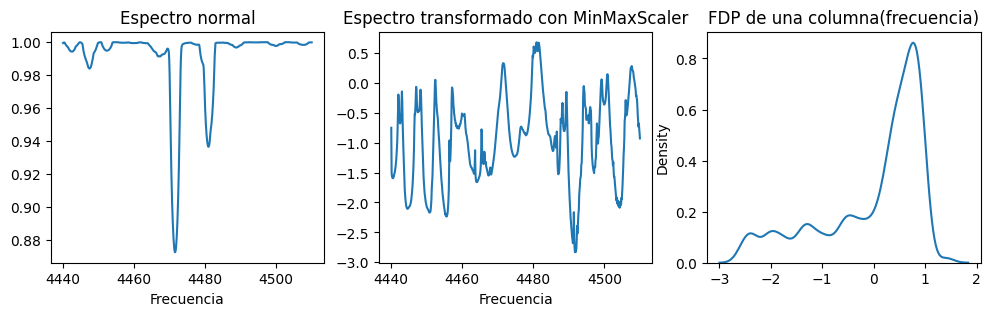

In [13]:
fig, axis = plt.subplots(1, 3, figsize=(12,3))
axis[0].plot(X.columns.map(float),X.iloc[0]); axis[0].set_xlabel('Frecuencia') ; axis[0].set_title('Espectro normal')
axis[1].plot(X.columns.map(float),x_train[0]); axis[1].set_xlabel('Frecuencia') ; axis[1].set_title('Espectro transformado con MinMaxScaler')
sns.kdeplot(x_train[:,0],ax=axis[2]); axis[2].set_title('FDP de una columna(frecuencia)')

In [14]:
#https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
from keras.optimizers import Adam
from sklearn.model_selection import KFold, StratifiedKFold

kf = KFold(n_splits = 5)

TESTING_LOSS = []
TESTING_MAE = []
VALIDAITON_LOSS = []
VALIDATION_MAE = []
fold_var = 1

for train_index, val_index in kf.split(x_train,y_train):
	x_training = x_train[train_index]
	x_validation = x_train[val_index]
	y_training = y_train[train_index]
	y_validation = y_train[val_index]
	
	# CREATE NEW MODEL
	model = generate_model()
	# COMPILE NEW MODEL
	model.compile(loss='MSE',
		      optimizer=Adam(),
		      metrics=['MAE'])
	
	# FIT THE MODEL
	history = model.fit(
  	x = x_training,
  	y = y_training,
		epochs=10,
		validation_data=(x_validation,y_validation))
 
	results = model.evaluate(x_val,y_val)
	results = dict(zip(model.metrics_names,results))
	
	VALIDAITON_LOSS.append(results['loss'])
	VALIDATION_MAE.append(results['MAE'])
 
	results = model.evaluate(x_obs,y_obs)
	results = dict(zip(model.metrics_names,results))
	
	TESTING_LOSS.append(results['loss'])
	TESTING_MAE.append(results['MAE'])
	
	tf.keras.backend.clear_session()
	
	fold_var += 1

Epoch 1/10
489/489 [==============================] - 5s 9ms/step - loss: 0.0362 - MAE: 0.1398 - val_loss: 0.0127 - val_MAE: 0.0814
Epoch 2/10
489/489 [==============================] - 4s 8ms/step - loss: 0.0102 - MAE: 0.0710 - val_loss: 0.0069 - val_MAE: 0.0573
Epoch 3/10
489/489 [==============================] - 4s 8ms/step - loss: 0.0059 - MAE: 0.0525 - val_loss: 0.0055 - val_MAE: 0.0496
Epoch 4/10
489/489 [==============================] - 4s 8ms/step - loss: 0.0040 - MAE: 0.0434 - val_loss: 0.0026 - val_MAE: 0.0342
Epoch 5/10
489/489 [==============================] - 4s 8ms/step - loss: 0.0028 - MAE: 0.0366 - val_loss: 0.0024 - val_MAE: 0.0339
Epoch 6/10
489/489 [==============================] - 4s 8ms/step - loss: 0.0022 - MAE: 0.0325 - val_loss: 0.0020 - val_MAE: 0.0289
Epoch 7/10
489/489 [==============================] - 4s 9ms/step - loss: 0.0016 - MAE: 0.0284 - val_loss: 0.0013 - val_MAE: 0.0267
Epoch 8/10
489/489 [==============================] - 4s 8ms/step - loss: 0.

In [15]:
valMAE['Std'] = VALIDATION_MAE
obsMAE['Std'] = TESTING_MAE

# 5. Normalization Layer

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

target = ['temperature','g','v']


X = B_df.drop(target,axis = 1)
Y = B_df[target]

X_obs = Obs_df.drop(target,axis=1)
Y_obs = Obs_df[target]

y_scaler = MinMaxScaler()

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42)

#x_train = np.random.normal(loc=0, scale=0.01, size=x_train.shape) + x_train

y_scaler = y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)
y_obs = y_scaler.transform(Y_obs)

In [21]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers 

#input_shape = (4, 10, 128) = (batch_size, steps, vectorLength) = (batchsize, rotaciones, frecuencias)

normalize = layers.Normalization()
normalize.adapt(x_train)

# This layer will shift and scale inputs into a distribution centered around 0 with standard deviation 1.
# It accomplishes this by precomputing the mean and variance of the data and calling (input - mean) / sqrt(var) at runtime

input_shape = (x_train.shape[1],1)

def generate_model(): 
  return tf.keras.Sequential([
  keras.Input(shape=(701,1)),
  normalize,
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.MaxPooling1D(pool_size=3, padding='same'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.MaxPooling1D(pool_size=2, padding='same'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.MaxPooling1D(pool_size=2, padding='same'),
  layers.GlobalAveragePooling1D(),
  
  layers.Dense(128, activation='relu'),
  layers.Dense(3, activation='linear')
])

In [22]:
#https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
from keras.optimizers import Adam
from sklearn.model_selection import KFold, StratifiedKFold

kf = KFold(n_splits = 5)

TESTING_LOSS = []
TESTING_MAE = []
VALIDAITON_LOSS = []
VALIDATION_MAE = []
fold_var = 1

for train_index, val_index in kf.split(x_train,y_train):
	x_training = x_train.iloc[train_index]
	x_validation = x_train.iloc[val_index]
	y_training = y_train[train_index]
	y_validation = y_train[val_index]
	
	# CREATE NEW MODEL
	model = generate_model()
	# COMPILE NEW MODEL
	model.compile(loss='MSE',
		      optimizer=Adam(),
		      metrics=['MAE'])
	
	# FIT THE MODEL
	history = model.fit(
  	x = x_training,
  	y = y_training,
		epochs=10,
		validation_data=(x_validation,y_validation))
 
	results = model.evaluate(x_val,y_val)
	results = dict(zip(model.metrics_names,results))
	
	VALIDAITON_LOSS.append(results['loss'])
	VALIDATION_MAE.append(results['MAE'])
 
	results = model.evaluate(x_obs,y_obs)
	results = dict(zip(model.metrics_names,results))
	
	TESTING_LOSS.append(results['loss'])
	TESTING_MAE.append(results['MAE'])
	
	tf.keras.backend.clear_session()
	
	fold_var += 1

Epoch 1/10
489/489 [==============================] - 13s 25ms/step - loss: 0.0228 - MAE: 0.1026 - val_loss: 0.0110 - val_MAE: 0.0760
Epoch 2/10
489/489 [==============================] - 12s 25ms/step - loss: 0.0079 - MAE: 0.0617 - val_loss: 0.0038 - val_MAE: 0.0439
Epoch 3/10
489/489 [==============================] - 13s 26ms/step - loss: 0.0028 - MAE: 0.0381 - val_loss: 0.0012 - val_MAE: 0.0246
Epoch 4/10
489/489 [==============================] - 13s 26ms/step - loss: 9.1211e-04 - MAE: 0.0224 - val_loss: 5.5001e-04 - val_MAE: 0.0160
Epoch 5/10
489/489 [==============================] - 13s 26ms/step - loss: 6.9500e-04 - MAE: 0.0198 - val_loss: 8.2460e-04 - val_MAE: 0.0213
Epoch 6/10
489/489 [==============================] - 13s 26ms/step - loss: 7.2005e-04 - MAE: 0.0201 - val_loss: 0.0011 - val_MAE: 0.0262
Epoch 7/10
489/489 [==============================] - 13s 26ms/step - loss: 8.4925e-04 - MAE: 0.0218 - val_loss: 0.0013 - val_MAE: 0.0293
Epoch 8/10
489/489 [==================

In [23]:
valMAE['NormLayer'] = VALIDATION_MAE
obsMAE['NormLayer'] = TESTING_MAE

# 6. Results

Text(0, 0.5, 'MAE')

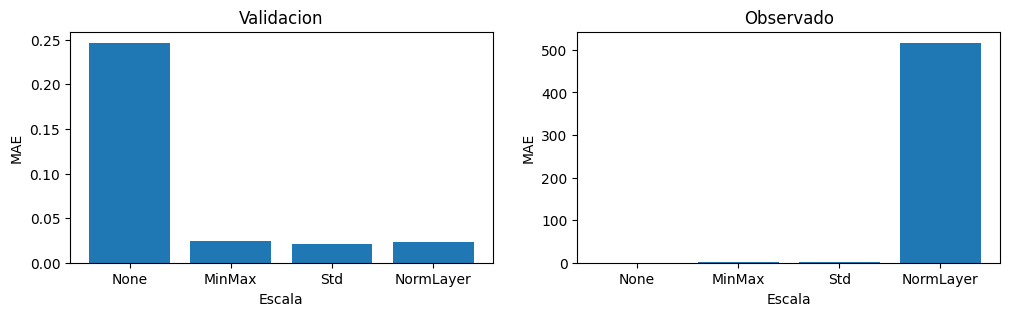

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12,3))
axes[0].bar(x=['None','MinMax','Std','NormLayer'],height=[np.mean(valMAE['None']),np.mean(valMAE['MinMax']),np.mean(valMAE['Std']),np.mean(valMAE['NormLayer'])])
axes[0].set_title('Validacion')
axes[0].set_xlabel('Escala')
axes[0].set_ylabel('MAE')

axes[1].bar(x=['None','MinMax','Std','NormLayer'],height=[np.mean(obsMAE['None']),np.mean(obsMAE['MinMax']),np.mean(obsMAE['Std']),np.mean(obsMAE['NormLayer'])])
axes[1].set_title('Observado')
axes[1].set_xlabel('Escala')
axes[1].set_ylabel('MAE')